In [3]:
import torch
import pandas as pd
from transformers import AutoProcessor, AutoModelForVision2Seq

# Load processor and model
model_name = "meta-llama/Llama-3.2-11B-Vision-Instruct"
processor = AutoProcessor.from_pretrained(model_name)
model = AutoModelForVision2Seq.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    attn_implementation="eager",
    output_attentions=True,
    return_dict=True
).to("cpu")

print("✅ Model & Processor Loaded!")

/opt/anaconda3/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:818: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_attentions` is. When `return_dict_in_generate` is not `True`, `output_attentions` is ignored.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

✅ Model & Processor Loaded!


In [4]:
# Input
prompt = "Who invented electricity?"
inputs = processor(text=prompt, return_tensors="pt")

# Run the model with attention and hidden states
with torch.no_grad():
    outputs = model(**inputs, output_hidden_states=True)
    outputs_result = model.generate(**inputs, max_new_tokens=50, output_attentions=True, return_dict_in_generate=True)

print("✅ Inputs processed, running inference...")
generated_texts = processor.batch_decode(outputs_result.sequences, skip_special_tokens=True)
generated_answer = generated_texts[0]
print("\n📝 **Generated Answer:**")
print("——————————————————————")
print(generated_answer)
print("——————————————————————\n")

✅ Inputs processed, running inference...

📝 **Generated Answer:**
——————————————————————
Who invented electricity? Benjamin Franklin?
Benjamin Franklin did not invent electricity, but he did conduct extensive research on the subject. He demonstrated the connection between lightning and electricity and proved that lightning is a form of electricity. Franklin's experiments with electricity led to the invention of many
——————————————————————



In [5]:
# Extract hidden state shapes
hidden_state_shapes = {
    f"Layer {i}": h.shape for i, h in enumerate(outputs.hidden_states)
}

# Extract attention shapes    
attention_shapes = {
    f"Attention Layer {i}": attn.shape for i, attn in enumerate(outputs.attentions)
}

# Convert to DataFrames
df_hidden = pd.DataFrame(hidden_state_shapes.items(), columns=["Layer", "Hidden State Shape"])
df_attn = pd.DataFrame(attention_shapes.items(), columns=["Layer", "Attention Shape"])

In [6]:
print("\n📦 Hidden State Shapes:")
print(df_hidden)

print("\n🔍 Attention Map Shapes:")
print(df_attn)


📦 Hidden State Shapes:
       Layer Hidden State Shape
0    Layer 0       (1, 6, 4096)
1    Layer 1       (1, 6, 4096)
2    Layer 2       (1, 6, 4096)
3    Layer 3       (1, 6, 4096)
4    Layer 4       (1, 6, 4096)
5    Layer 5       (1, 6, 4096)
6    Layer 6       (1, 6, 4096)
7    Layer 7       (1, 6, 4096)
8    Layer 8       (1, 6, 4096)
9    Layer 9       (1, 6, 4096)
10  Layer 10       (1, 6, 4096)
11  Layer 11       (1, 6, 4096)
12  Layer 12       (1, 6, 4096)
13  Layer 13       (1, 6, 4096)
14  Layer 14       (1, 6, 4096)
15  Layer 15       (1, 6, 4096)
16  Layer 16       (1, 6, 4096)
17  Layer 17       (1, 6, 4096)
18  Layer 18       (1, 6, 4096)
19  Layer 19       (1, 6, 4096)
20  Layer 20       (1, 6, 4096)
21  Layer 21       (1, 6, 4096)
22  Layer 22       (1, 6, 4096)
23  Layer 23       (1, 6, 4096)
24  Layer 24       (1, 6, 4096)
25  Layer 25       (1, 6, 4096)
26  Layer 26       (1, 6, 4096)
27  Layer 27       (1, 6, 4096)
28  Layer 28       (1, 6, 4096)
29  Layer 29    

🔤 Original Tokens: ['<|begin_of_text|>', '<|begin_of_text|>', 'Who', 'Ġinvented', 'Ġelectricity', '?']


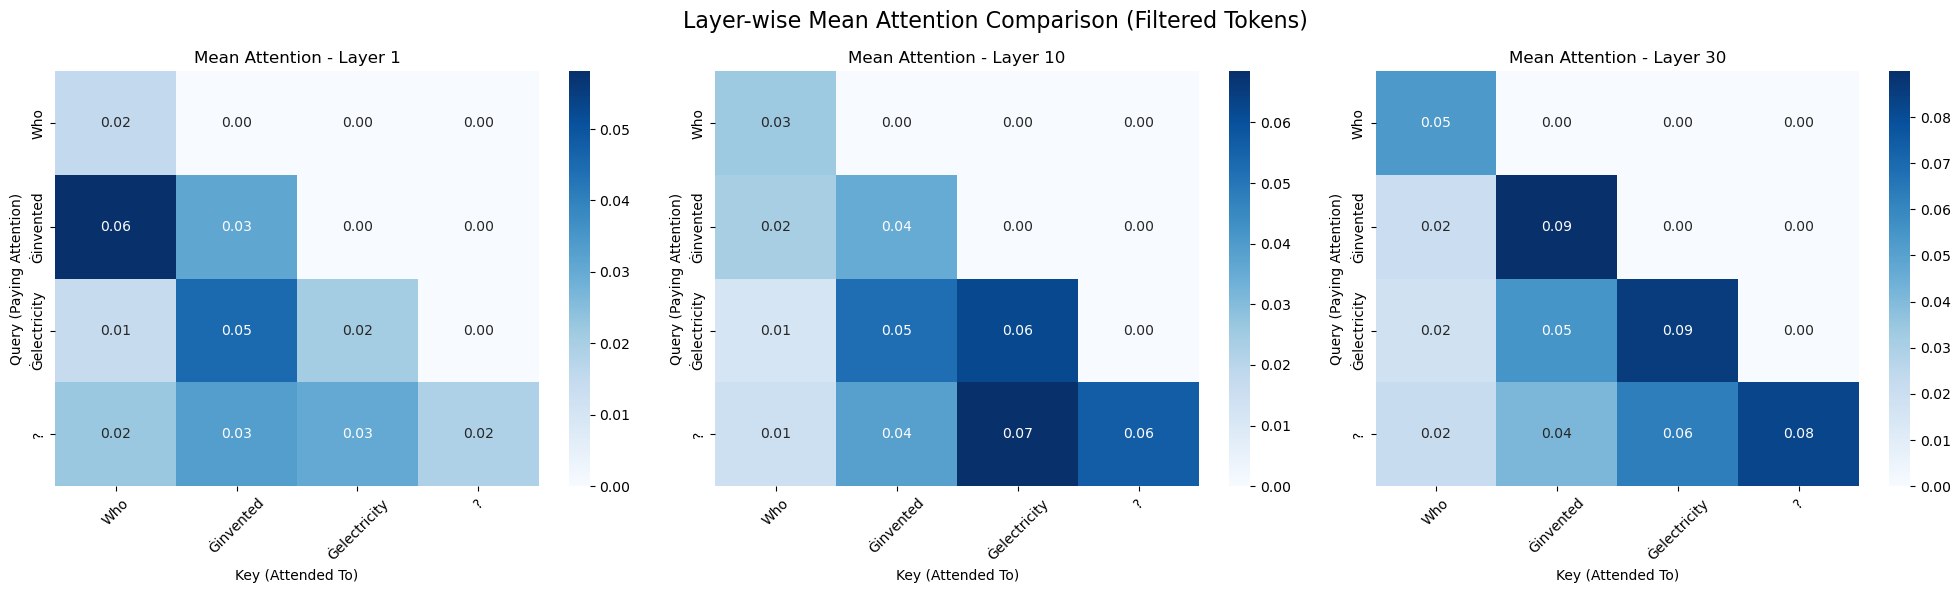

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

# 🔤 Convert token IDs to readable tokens
tokens = processor.tokenizer.convert_ids_to_tokens(inputs.input_ids[0])
print("🔤 Original Tokens:", tokens)

# 🧹 Filter out special tokens
filtered_tokens = []
keep_indices = []

for idx, token in enumerate(tokens):
    if token not in ["<|begin_of_text|>", "<s>", "</s>"]:
        filtered_tokens.append(token)
        keep_indices.append(idx)

# ✅ Layers to compare
layers_to_plot = [1, 10, 30]
fig, axes = plt.subplots(1, len(layers_to_plot), figsize=(20, 6))

for i, layer in enumerate(layers_to_plot):
    attn_all_heads = outputs.attentions[layer][0]  # shape: [num_heads, seq_len, seq_len]
    attn_mean = attn_all_heads.mean(dim=0)
    attn_filtered = attn_mean[keep_indices, :][:, keep_indices]

    sns.heatmap(attn_filtered.cpu().numpy(),
                xticklabels=filtered_tokens,
                yticklabels=filtered_tokens,
                cmap="Blues",
                annot=True,
                fmt=".2f",
                ax=axes[i])
    axes[i].set_title(f"Mean Attention - Layer {layer}")
    axes[i].set_xlabel("Key (Attended To)")
    axes[i].set_ylabel("Query (Paying Attention)")
    axes[i].tick_params(axis='x', rotation=45)

plt.suptitle("Layer-wise Mean Attention Comparison (Filtered Tokens)", fontsize=16)
plt.tight_layout()
plt.show()

In [8]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import imageio

# Define where to save images
save_dir = "attention_frames"
os.makedirs(save_dir, exist_ok=True)

# Get tokens from input
tokens = processor.tokenizer.convert_ids_to_tokens(inputs.input_ids[0])
layers_to_plot = list(range(0, len(outputs.attentions)))  # fewer layers (every 4th layer)

image_paths = []

for i in layers_to_plot:
    attn_all_heads = outputs.attentions[i][0]  # shape: [num_heads, seq_len, seq_len]
    attn_mean = attn_all_heads.mean(dim=0)

    plt.figure(figsize=(6, 5))
    sns.heatmap(attn_mean.cpu().numpy(), xticklabels=tokens, yticklabels=tokens, cmap="Blues", annot=False)
    plt.title(f"Layer {i} - Mean Attention")
    plt.xlabel("Key (Attended To)")
    plt.ylabel("Query (Paying Attention)")
    plt.xticks(rotation=45)
    plt.tight_layout()

    path = f"{save_dir}/layer_{i}.png"
    plt.savefig(path, dpi=80)
    image_paths.append(path)
    plt.close()

# Generate GIF
with imageio.get_writer("attention_across_layers.gif", mode='I', duration=0.8) as writer:
    for filename in image_paths:
        image = imageio.imread(filename)
        writer.append_data(image)

print("✅ GIF saved as 'attention_across_layers.gif'")

✅ GIF saved as 'attention_across_layers.gif'


/var/folders/w5/81rp1d0x34nd8g9c4y0lbncc0000gn/T/ipykernel_1300/2324359874.py:36: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


In [6]:
model

MllamaForConditionalGeneration(
  (vision_model): MllamaVisionModel(
    (patch_embedding): Conv2d(3, 1280, kernel_size=(14, 14), stride=(14, 14), padding=valid, bias=False)
    (gated_positional_embedding): MllamaPrecomputedPositionEmbedding(
      (tile_embedding): Embedding(9, 8197120)
    )
    (pre_tile_positional_embedding): MllamaPrecomputedAspectRatioEmbedding(
      (embedding): Embedding(9, 5120)
    )
    (post_tile_positional_embedding): MllamaPrecomputedAspectRatioEmbedding(
      (embedding): Embedding(9, 5120)
    )
    (layernorm_pre): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
    (layernorm_post): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
    (transformer): MllamaVisionEncoder(
      (layers): ModuleList(
        (0-31): 32 x MllamaVisionEncoderLayer(
          (self_attn): MllamaVisionAttention(
            (q_proj): Linear(in_features=1280, out_features=1280, bias=False)
            (k_proj): Linear(in_features=1280, out_features=1280, bias=

In [8]:
next_token_id = torch.argmax(outputs.logits[0, -1]).item()
next_token = processor.tokenizer.decode(next_token_id)
print("🔮 Predicted next token:", next_token)

🔮 Predicted next token:  Benjamin


In [8]:
import os
# ✅ Create output directory
output_dir = "./attention_maps_llama_3.2"
os.makedirs(output_dir, exist_ok=True)

# ✅ Save heatmap for each layer and head
num_layers = len(outputs.attentions)
num_heads = outputs.attentions[0].shape[1]

print(f"📊 Saving attention maps for {num_layers} layers × {num_heads} heads")

for layer in range(num_layers):
    for head in range(num_heads):
        attn = outputs.attentions[layer][0, head]  # [seq_len, seq_len]
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(attn.numpy(), xticklabels=tokens, yticklabels=tokens, cmap="coolwarm", annot=False)
        plt.title(f"Layer {layer} - Head {head}")
        plt.xlabel("Keys")
        plt.ylabel("Queries")
        plt.xticks(rotation=45)
        plt.tight_layout()
        
        filename = f"{output_dir}/attention_layer{layer}_head{head}.png"
        plt.savefig(filename)
        plt.close()

print(f"✅ Attention heatmaps saved to: {output_dir}")

📊 Saving attention maps for 32 layers × 32 heads
✅ Attention heatmaps saved to: ./attention_maps_llama_3.2
